# 02. Spanish Translate A/B Test

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
%matplotlib inline

In [6]:
from platform import python_version
print(python_version())

3.6.10


In [7]:
%%HTML
<style type="text/css">
table.dataframe td, table.dataframe th {
    border: 1px solid lightgray;
}

## Data Processing 

In [17]:
test=pd.read_csv("E:/Collection_DS_takehome_challenges/Data/test_table.csv")
test.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1


In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 453321 entries, 0 to 453320
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   user_id           453321 non-null  int64 
 1   date              453321 non-null  object
 2   source            453321 non-null  object
 3   device            453321 non-null  object
 4   browser_language  453321 non-null  object
 5   ads_channel       181877 non-null  object
 6   browser           453321 non-null  object
 7   conversion        453321 non-null  int64 
 8   test              453321 non-null  int64 
dtypes: int64(3), object(6)
memory usage: 31.1+ MB


In [24]:
test.describe().round(2)

,user_id,conversion,test
count,453321.00,453321.00,453321.00
mean,499937.51,0.05,0.48
std,288665.19,0.22,0.50
min,1.00,0.00,0.00
25%,249816.00,0.00,0.00
50%,500019.00,0.00,0.00
75%,749522.00,0.00,1.00
max,1000000.00,1.00,1.00


In [13]:
user=pd.read_csv("E:/Collection_DS_takehome_challenges/Data/user_table.csv")
user.head()

,user_id,sex,age,country
0,765821,M,20,Mexico
1,343561,F,27,Nicaragua
2,118744,M,23,Colombia
3,987753,F,27,Venezuela
4,554597,F,20,Spain


In [14]:
user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 452867 entries, 0 to 452866
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   user_id  452867 non-null  int64 
 1   sex      452867 non-null  object
 2   age      452867 non-null  int64 
 3   country  452867 non-null  object
dtypes: int64(2), object(2)
memory usage: 13.8+ MB


In [25]:
user.describe().round(2)

,user_id,age
count,452867.00,452867.00
mean,499944.81,27.13
std,288676.26,6.78
min,1.00,18.00
25%,249819.00,22.00
50%,500019.00,26.00
75%,749543.00,31.00
max,1000000.00,70.00


In [29]:
# Check uniqueness
print('Test ID:\t',len(test['user_id'].unique()), '\t', len(test['user_id'].unique())==len(test))
print('User ID:\t',len(user['user_id'].unique()), '\t', len(user['user_id'].unique())==len(user))

Test ID:	 453321 	 True
User ID:	 452867 	 True


In [76]:
# Merge Two Tables
data= pd.merge(left=test,right=user,how='left',on='user_id') # not use 'inner', will lost users in test table
data.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0,M,32.0,Spain
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1,M,21.0,Mexico
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0,M,34.0,Spain
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1,F,22.0,Mexico
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1,M,19.0,Mexico


Looks like the user table is busted and we have some user ids missing. When joining, we have to be
careful to do not lose the user ids in the test table, but not in the user table.

In [77]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 453321 entries, 0 to 453320
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   user_id           453321 non-null  int64  
 1   date              453321 non-null  object 
 2   source            453321 non-null  object 
 3   device            453321 non-null  object 
 4   browser_language  453321 non-null  object 
 5   ads_channel       181877 non-null  object 
 6   browser           453321 non-null  object 
 7   conversion        453321 non-null  int64  
 8   test              453321 non-null  int64  
 9   sex               452867 non-null  object 
 10  age               452867 non-null  float64
 11  country           452867 non-null  object 
dtypes: float64(1), int64(3), object(8)
memory usage: 45.0+ MB


## A/B Test

In [94]:
# First check that Spain converts much better than the rest of LatAm countries
groupby_country=data[data['test']==0][['country','conversion']].groupby('country').mean()
groupby_country=groupby_country.sort_values('conversion',ascending=False).reset_index()
print(groupby_country)

        country  conversion
0         Spain    0.079719
1   El Salvador    0.053554
2     Nicaragua    0.052647
3    Costa Rica    0.052256
4      Colombia    0.052089
5      Honduras    0.050906
6     Guatemala    0.050643
7     Venezuela    0.050344
8          Peru    0.049914
9        Mexico    0.049495
10      Bolivia    0.049369
11      Ecuador    0.049154
12     Paraguay    0.048493
13        Chile    0.048107
14       Panama    0.046796
15    Argentina    0.015071
16      Uruguay    0.012048


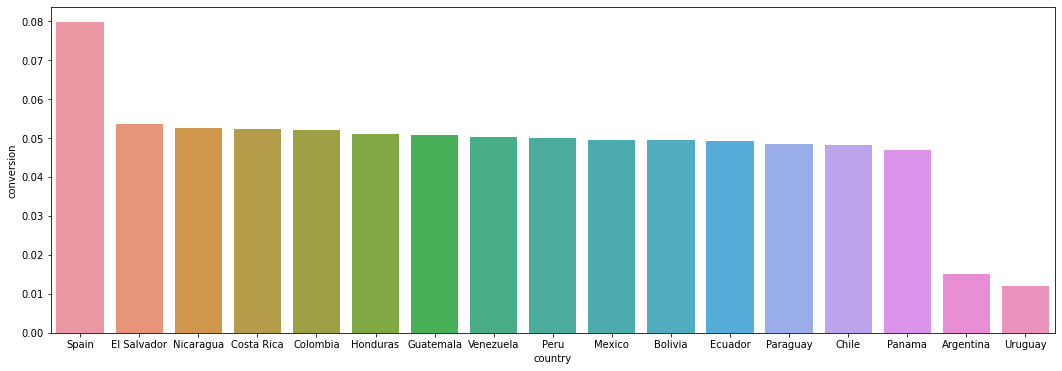

In [80]:
# Visualization
fig,ax=plt.subplots(figsize=(18,6))
sns.barplot(x='country',y='conversion',data=groupby_country,ax=ax)
plt.show()

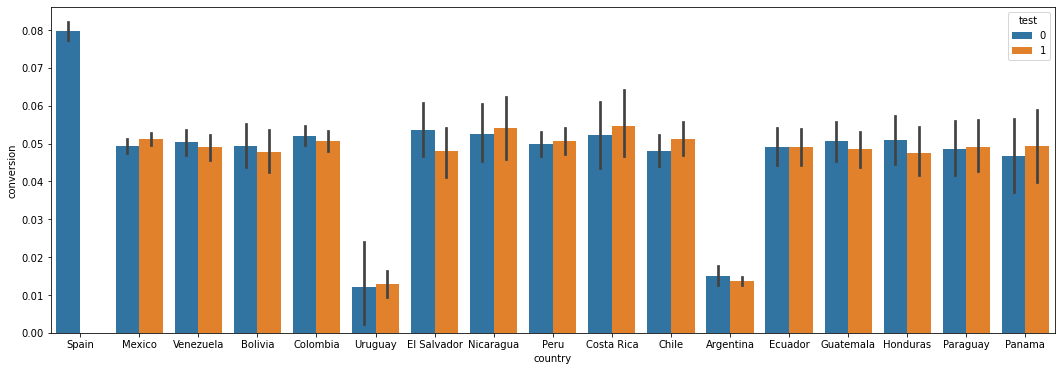

In [38]:
# Visualization
fig,ax=plt.subplots(figsize=(18,6))
sns.barplot(x='country',y='conversion',hue='test',data=data,ax=ax)
plt.show()


In [78]:
# A/B test
test_data=data[data['country']!='Spain']
test_val=test_data[test_data['test']==1]['conversion'].values
cont_val=test_data[test_data['test']==0]['conversion'].values
print(test_val.mean(),'\t',cont_val.mean())

0.043424713982118966 	 0.04833042316066309


In [79]:
print(ttest_ind(test_val,cont_val,equal_var=False))

Ttest_indResult(statistic=-7.3939374121344805, pvalue=1.4282994754055316e-13)


Mmh…not in the test are converting at 4.8% while users in the test just at 4.3%. That’s a 10% drop,..
which would be dramatic if it were true. The most likely reason for weird A/B test results are:
.... We didn’t collect enough data.
.... Some bias has been introduced in the experiment so that test/control people are not really
random.

## Analysis

In [44]:
test_data=test_data.sort_values('date')
test_data.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country
404193,251642,2015-11-30,Direct,Web,ES,NaN,IE,0,0,M,40.0,Mexico
192309,702198,2015-11-30,SEO,Web,ES,NaN,IE,0,0,M,20.0,Peru
192308,933036,2015-11-30,Direct,Mobile,EN,NaN,Android_App,0,1,M,26.0,Peru
192296,81984,2015-11-30,SEO,Mobile,Other,NaN,Android_App,0,0,F,26.0,Peru
192290,917170,2015-11-30,Ads,Web,ES,Google,Safari,0,1,F,21.0,Peru


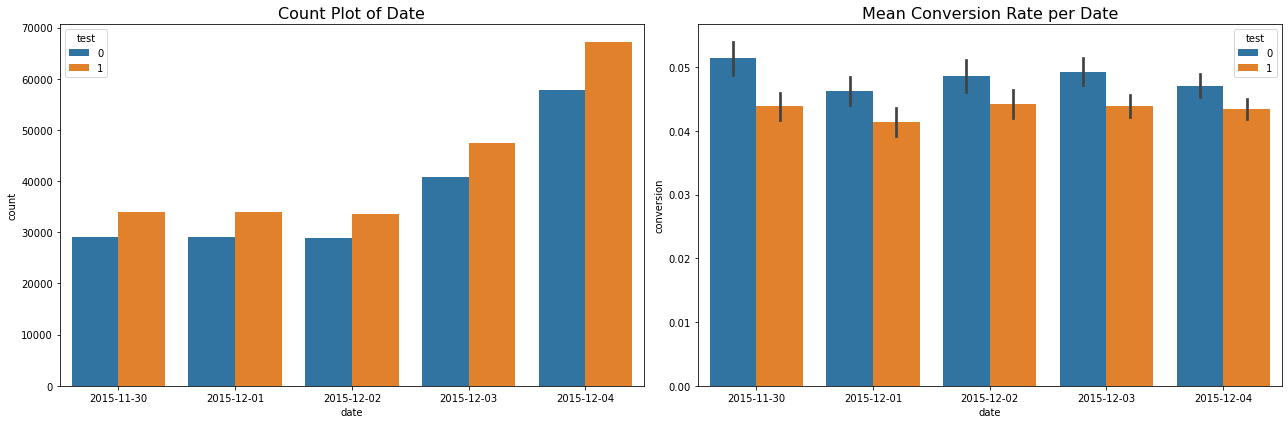

In [45]:
# Visualization of different dates
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='date', hue='test', data=test_data, ax=ax[0])
ax[0].set_title('Count Plot of Date', fontsize=16)

sns.barplot(x='date', y='conversion', hue='test', data=test_data, ax=ax[1])
ax[1].set_title('Mean Conversion Rate per Date', fontsize=16)
plt.tight_layout()
plt.show()

 1. Test has constantly been worse than control and there is relatively little variance across days. That probably means that we do have enough data, but there was some bias in the experiment set up.
 2. On a side note, we just ran it for 5 days. We should always run the test for at least 1 full week to capture weekly patterns, 2 weeks would be much better.

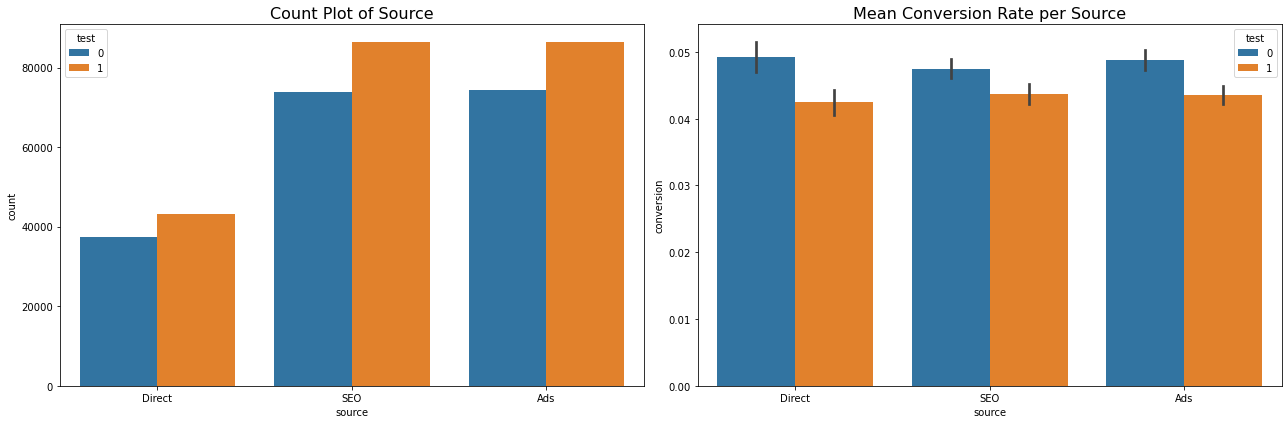

In [46]:
# Visualization of different source
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='source', hue='test', data=test_data, ax=ax[0])
ax[0].set_title('Count Plot of Source', fontsize=16)

sns.barplot(x='source', y='conversion', hue='test', data=test_data, ax=ax[1])
ax[1].set_title('Mean Conversion Rate per Source', fontsize=16)
plt.tight_layout()
plt.show()

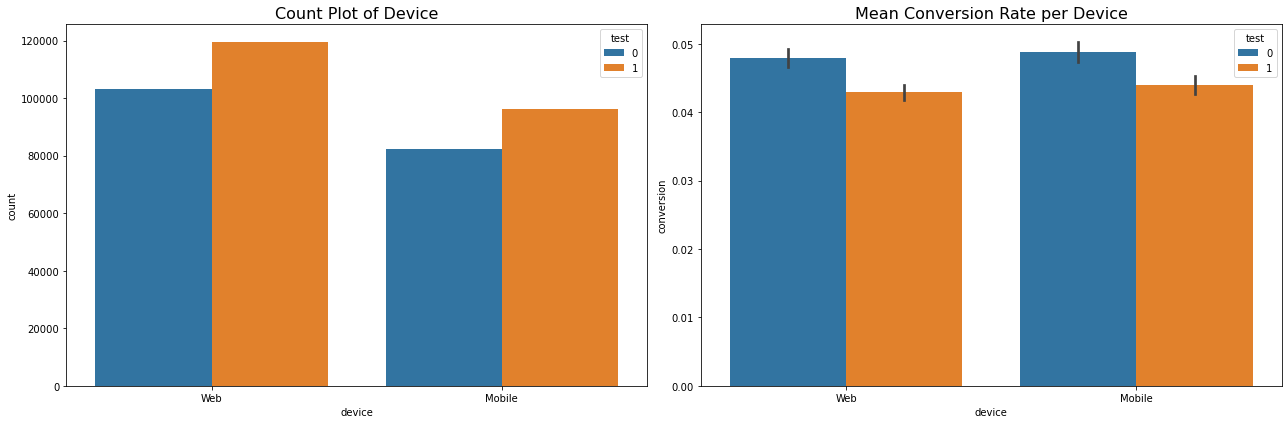

In [49]:
# Visualization of different device
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='device', hue='test', data=test_data, ax=ax[0])
ax[0].set_title('Count Plot of Device', fontsize=16)

sns.barplot(x='device', y='conversion', hue='test', data=test_data, ax=ax[1])
ax[1].set_title('Mean Conversion Rate per Device', fontsize=16)
plt.tight_layout()
plt.show()

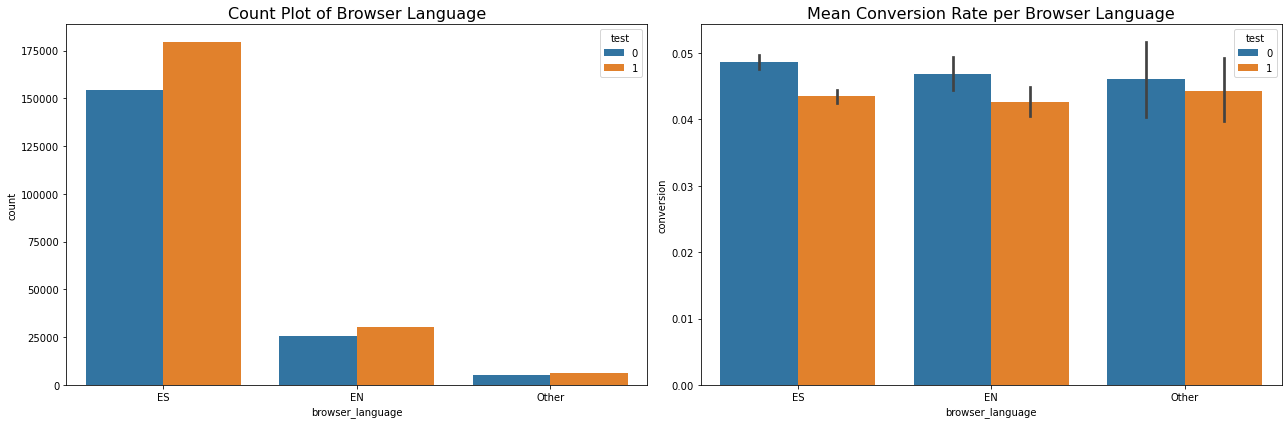

In [50]:
# Visualization of different browser language
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='browser_language', hue='test', data=test_data, ax=ax[0])
ax[0].set_title('Count Plot of Browser Language', fontsize=16)

sns.barplot(x='browser_language', y='conversion', hue='test', data=test_data, ax=ax[1])
ax[1].set_title('Mean Conversion Rate per Browser Language', fontsize=16)
plt.tight_layout()
plt.show()

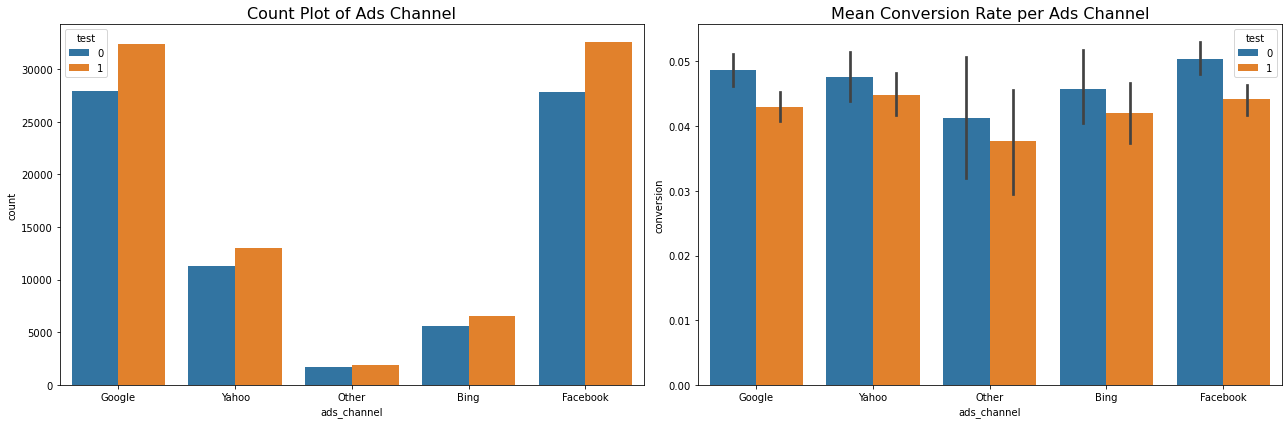

In [52]:
# Visualization of different ads channel
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='ads_channel', hue='test', data=test_data, ax=ax[0])
ax[0].set_title('Count Plot of Ads Channel', fontsize=16)

sns.barplot(x='ads_channel', y='conversion', hue='test', data=test_data, ax=ax[1])
ax[1].set_title('Mean Conversion Rate per Ads Channel', fontsize=16)
plt.tight_layout()
plt.show()

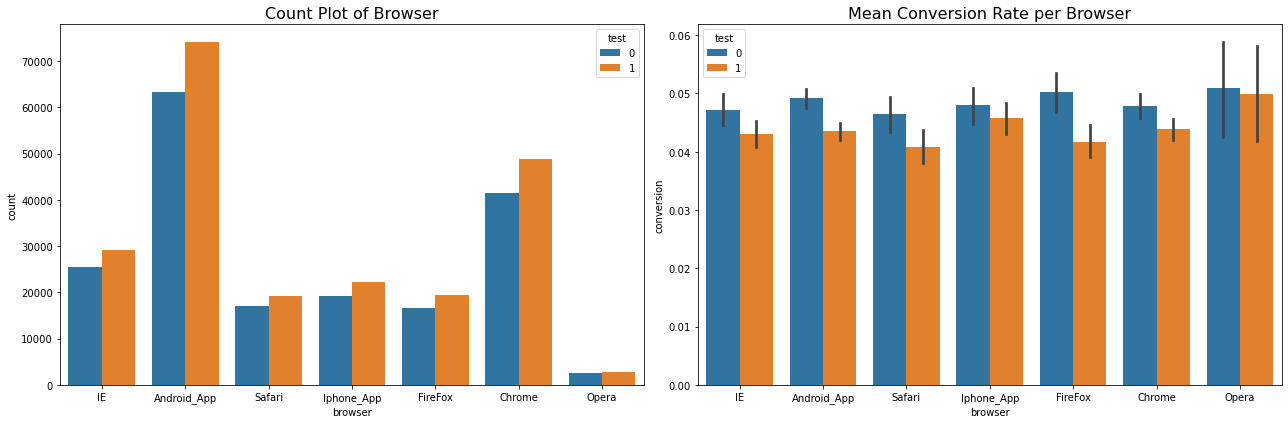

In [53]:
# Visualization of different browser
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='browser', hue='test', data=test_data, ax=ax[0])
ax[0].set_title('Count Plot of Browser', fontsize=16)

sns.barplot(x='browser', y='conversion', hue='test', data=test_data, ax=ax[1])
ax[1].set_title('Mean Conversion Rate per Browser', fontsize=16)
plt.tight_layout()
plt.show()

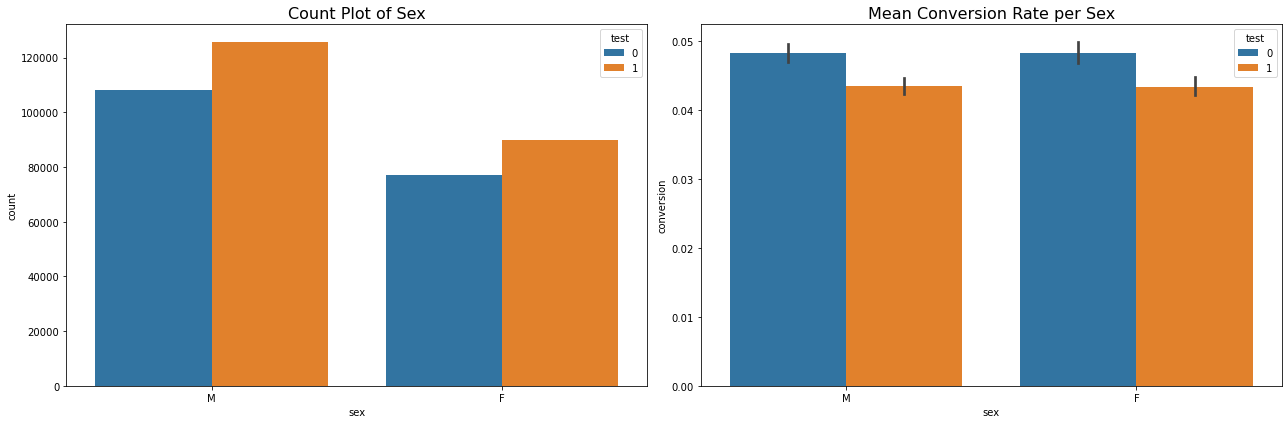

In [54]:
# Visualization of different Sex
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='sex', hue='test', data=test_data, ax=ax[0])
ax[0].set_title('Count Plot of Sex', fontsize=16)

sns.barplot(x='sex', y='conversion', hue='test', data=test_data, ax=ax[1])
ax[1].set_title('Mean Conversion Rate per Sex', fontsize=16)
plt.tight_layout()
plt.show()

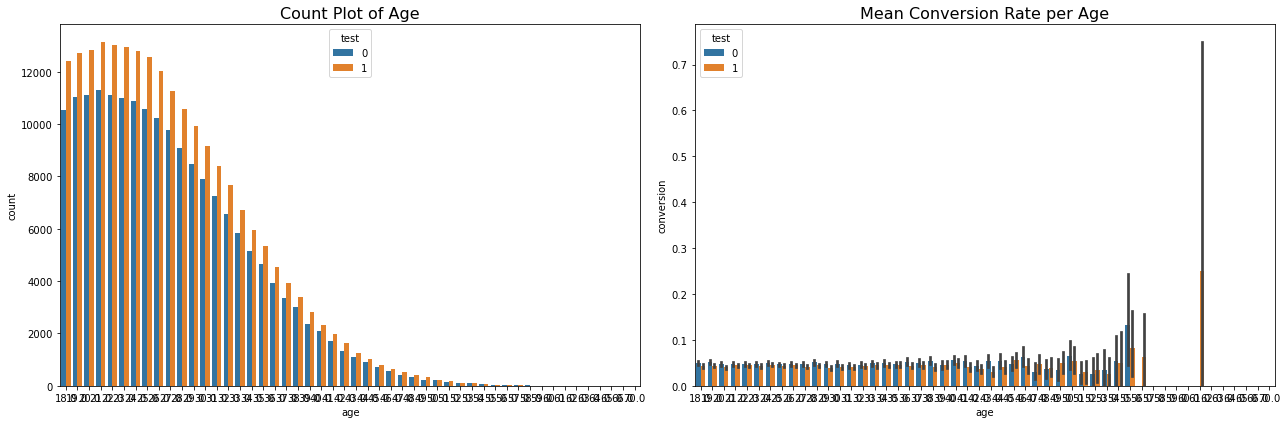

In [56]:
# Visualization of different Age
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='age', hue='test', data=test_data, ax=ax[0])
ax[0].set_title('Count Plot of Age', fontsize=16)

sns.barplot(x='age', y='conversion', hue='test', data=test_data, ax=ax[1])
ax[1].set_title('Mean Conversion Rate per Age', fontsize=16)
plt.tight_layout()
plt.show()

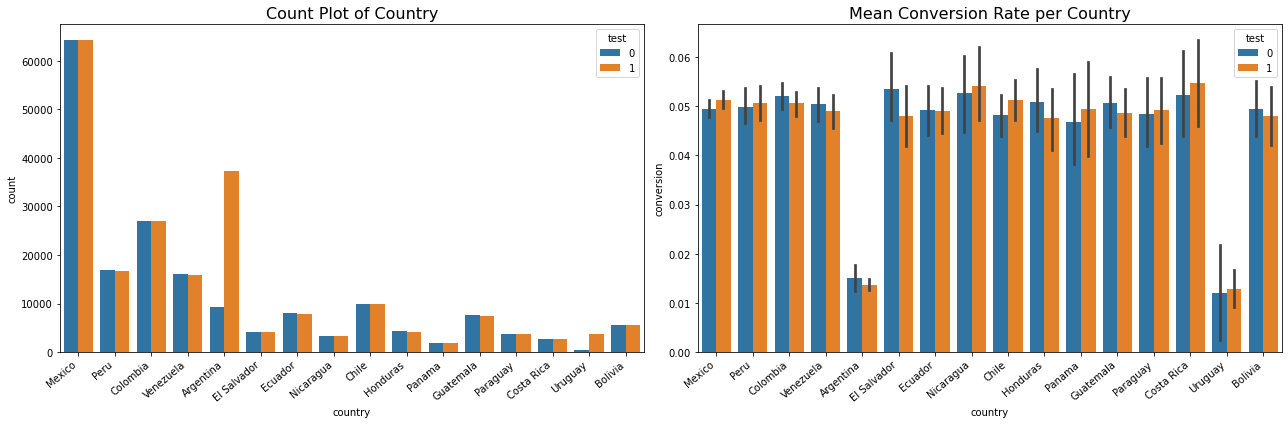

In [60]:
# Visualization of different Country
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='country', hue='test', data=test_data, ax=ax[0])
ax[0].set_title('Count Plot of Country', fontsize=16)
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=40, ha="right")
sns.barplot(x='country', y='conversion', hue='test', data=test_data, ax=ax[1])
ax[1].set_title('Mean Conversion Rate per Country', fontsize=16)
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

The randomization is perfect for the countries on one side of the split (country=Bolivia, Chile, Colombia, Costa Rica, Ecuador, EL Salvador, Guatemala, Honduras, Mexico,Nicaragua, Panama, Paraguay, Peru, Venezuela). Indeed, in that leaf the test/control ratio is 0.498! However, Argentina and Uruguay together have 80% test and 20% control!

In [68]:
countries=[name for name in test_data['country'].unique() if name is not np.nan]
countries.sort()
print(countries)
print('{0:15s} {1:>15s} {2:>15s} {3:>10s}'.format('Country','Test Rate','Control Rate','P-Value'))
print('-'*65)
for country in countries:
    test_val=test_data[(test_data['country']==country)&(test_data['test']==1)]['conversion'].values
    cont_val=test_data[(test_data['country']==country)&(test_data['test']==0)]['conversion'].values
    test_mean=test_val.mean()
    cont_mean=cont_val.mean()
    p_val=ttest_ind(test_val,cont_val,equal_var=False).pvalue
    print('{0:15s} {1:15.5f} {2:15.5f} {3:10f}'.format(country,test_mean,cont_mean,p_val))


['Argentina', 'Bolivia', 'Chile', 'Colombia', 'Costa Rica', 'Ecuador', 'El Salvador', 'Guatemala', 'Honduras', 'Mexico', 'Nicaragua', 'Panama', 'Paraguay', 'Peru', 'Uruguay', 'Venezuela']
Country               Test Rate    Control Rate    P-Value
-----------------------------------------------------------------
Argentina               0.01373         0.01507   0.335147
Bolivia                 0.04790         0.04937   0.718885
Chile                   0.05130         0.04811   0.302848
Colombia                0.05057         0.05209   0.423719
Costa Rica              0.05474         0.05226   0.687876
Ecuador                 0.04899         0.04915   0.961512
El Salvador             0.04795         0.05355   0.248127
Guatemala               0.04865         0.05064   0.572107
Honduras                0.04754         0.05091   0.471463
Mexico                  0.05119         0.04949   0.165544
Nicaragua               0.05418         0.05265   0.780400
Panama                  0.04937       

After we control for country, the test clearly appears non significant. Not a great success given that the goal was to improve conversion rate, but at least we know that a localized translation didn’t make things worse!